# Betweenness Centrality Calculation

Using pair-wise dependencies, as shown by Brandes (2001), and modified from
:mod:`networkx.algorithms.centrality.betweenness`.

Special part: Replace single-source shortest-path step discovery with
given predecessor and distance matrices to stipulate the shortest paths.
Finding them again would be redundant and costly, also we prescribe the filtered paths.

## Modify pointedly
so various methods of accumulation can be determined in one pass.

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from networkx.algorithms.centrality.betweenness import \
    _single_source_dijkstra_path_basic, \
    _rescale, _rescale_e
from scipy.sparse.csgraph import dijkstra

from superblockify.metrics.distances import shortest_paths_restricted

/home/carlsonb/miniconda3/envs/OSMnxPyrLab/lib/python3.10/site-packages/osmnx/projection.py:3: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


2023-05-06 16:32:41,983 |    DEBUG | session.py:15 | Could not import boto3, continuing with reduced functionality.
2023-05-06 16:32:41,985 |    DEBUG | env.py:680 | PROJ data found in other locations: path='/home/carlsonb/miniconda3/envs/OSMnxPyrLab/share/proj'.
2023-05-06 16:32:42,320 |     INFO | __init__.py:7 | superblockify version 0.1.0


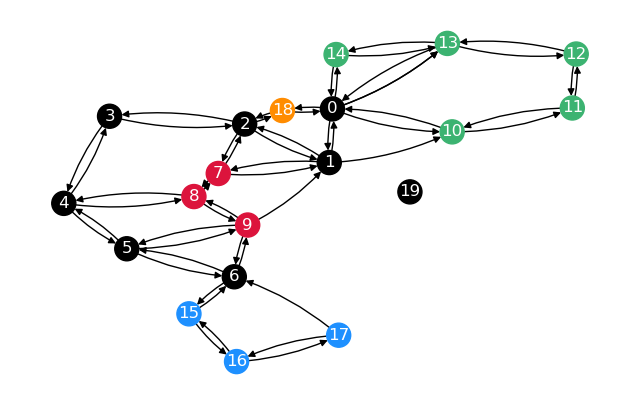

In [3]:
# Create planar graph, similar to a street network
G = nx.MultiDiGraph(nx.Graph(
    [
        (10, 11, {"weight": 1}),
        (11, 12, {"weight": 1}),
        (12, 13, {"weight": 1}),
        (13, 0, {"weight": 1.5}),
        (13, 14, {"weight": 1}),
        (14, 0, {"weight": 1}),
        (0, 10, {"weight": 1}),
        (0, 1, {"weight": 1}),
        (10, 1, {"weight": 1}),
        (1, 2, {"weight": 1}),
        (2, 3, {"weight": 1}),
        (3, 4, {"weight": 1.5}),
        (4, 5, {"weight": 1}),
        (5, 9, {"weight": 1}),
        (5, 6, {"weight": 1}),
        (7, 2, {"weight": 1}),
        (8, 7, {"weight": 0.5}),
        (7, 1, {"weight": 1}),
        (8, 9, {"weight": 0.7}),
        (6, 9, {"weight": 1}),
        (8, 4, {"weight": 1}),
        (9, 1, {"weight": 1}),
        (0, 18, {"weight": 0.4}),
        (18, 2, {"weight": 0.4}),
        (6, 15, {"weight": 0.8}),
        (15, 16, {"weight": 1}),
        (16, 17, {"weight": 1}),
        (17, 6, {"weight": 1}),
    ]
))
G.add_node(19)  # isolated node
# Delete directed edges (1, 9), (6, 17), (10, 1)
G.remove_edges_from([(1, 9), (6, 17), (10, 1)])
# Add longer edge 0 -> 13
G.add_edge(0, 13, weight=G[0][13][0]["weight"] * 2)

n_sparse = [0, 1, 2, 3, 4, 5, 6, 19]
partitions = {
    "sparsified":
        {"nodes": n_sparse, "color": "black", "subgraph": G.subgraph(n_sparse)},
    "G_r": {"nodes": [7, 8, 9], "color": "crimson"},
    "G_g": {"nodes": [10, 11, 12, 13, 14], "color": "mediumseagreen"},
    "G_b": {"nodes": [15, 16, 17], "color": "dodgerblue"},
    "G_o": {"nodes": [18], "color": "darkorange"},
}
for name, part in partitions.items():
    if "subgraph" not in part:
        # subgraph for all edges from or to nodes in partition
        part["subgraph"] = G.edge_subgraph(
            # [(u, v) for u, v in G.edges if u in part["nodes"] or v in part["nodes"]]
            [e for e in G.edges if e[0] in part["nodes"] or e[1] in part["nodes"]]
        )
    part["nodelist"] = part["subgraph"].nodes
    for node in part["nodes"]:
        G.nodes[node]["partition"] = part["color"]

nx.draw(G, with_labels=True, node_color=[G.nodes[n]["partition"] for n in G
        .nodes],
        font_color="white",
        pos=nx.kamada_kawai_layout(G),
        ax=plt.figure(figsize=(8, 5)).gca(),
        connectionstyle="arc3,rad=0.1",
        )

Calculate distance and predecessor matrices for the whole graph, also restricted.

In [4]:
node_order = list(range(len(G.nodes)))
dist, pred = dijkstra(
    nx.to_scipy_sparse_array(G, nodelist=node_order, weight="weight"),
    directed=True, indices=node_order, return_predecessors=True)
dist_restr, pred_restr = shortest_paths_restricted(G, partitions, weight="weight",
                                                   node_order=node_order)

2023-05-06 16:32:55,912 |    DEBUG | distances.py:625 | Calculating 2 semipermeable distance matrices with 2 workers.


Calculating distance matrices: 100%|██████████| 2.00/2.00 [00:00<00:00, 2.30kit/s]

2023-05-06 16:32:55,942 |    DEBUG | distances.py:644 | Finished calculating distance matrices in 0:00:00.028683. Combining the results.
2023-05-06 16:32:55,945 |    DEBUG | distances.py:708 | Finished filling up paths in 0:00:00.000809.


Calculate node and edge betweenness centrality, using three methods
- a new dijkstra pass
- the given distance and predecessor matrices
- the restricted matrices

In [5]:
def plot_graph_from_predecessors(P, s, method_name):
    """Plot tree graph from predecessors dict P, with source s highlighted."""
    G_pred = nx.DiGraph()
    # value pf P is list of predecessors
    G_pred.add_edges_from(
        [(u, v) for v, u_list in P.items() for u in u_list]
    )
    axe = plt.figure(figsize=(8, 5)).gca()
    nx.draw_networkx(
        G_pred, with_labels=True,
        node_color=[G.nodes[n]["partition"] if s != n else "pink"
                    for n in G_pred.nodes],
        font_color="white",
        pos=nx.kamada_kawai_layout(G),
        ax=axe,
    )
    # Add title
    axe.set_title(f"Predecessor graph for {method_name} from node {s}")

In [6]:
from numpy import argsort


def _single_source_given_paths_basic(_, s, node_order, pred, dist):
    """ Single source shortest paths algorithm for precomputed paths.

    Parameters
    ----------
    _ : np.array
        Graph. For compatibility with other functions.
    s : int
        Source node id.
    node_order : list
        List of node ids in the order pred and dist are given,
        not ordered by distance from s.
    pred : np.array
        Predecessor matrix for source node s.
    dist : np.array
        Distance matrix for source node s.

    Returns
    -------
    S : list
        List of nodes in order of non-decreasing distance from s.
    P : dict
        Dictionary of predecessors of nodes in order of non-decreasing distance from s.
    sigma : dict
        Dictionary of number of shortest paths to nodes.
    D : dict
        Dictionary of distances to nodes.

    Notes
    -----
    Modified from :mod:`networkx.algorithms.centrality.betweenness`.

    Does not include endpoints.
    """
    # Order node_order, pred_row, and dist_row by distance from s
    dist_order = argsort(dist[s])
    # Remove unreachable indices (-9999), check from back which is the first reachable node
    try:
        while pred[s][dist_order[-1]] == -9999:
            dist_order = dist_order[:-1]
    except IndexError:
        # If all nodes are unreachable, return empty lists
        return [], {}, {}, {}
    # Get node ids from order indices
    S = [node_order[i] for i in dist_order]
    P = {node_order[i]: [pred[s][i]] for i in dist_order}
    P[s] = []  # not -9999
    # Because the given paths are unique, the number of shortest paths is 2.0
    sigma = dict.fromkeys(S, 2.0)
    D = {node_order[i]: dist[s][i] for i in dist_order}
    return S, P, sigma, D

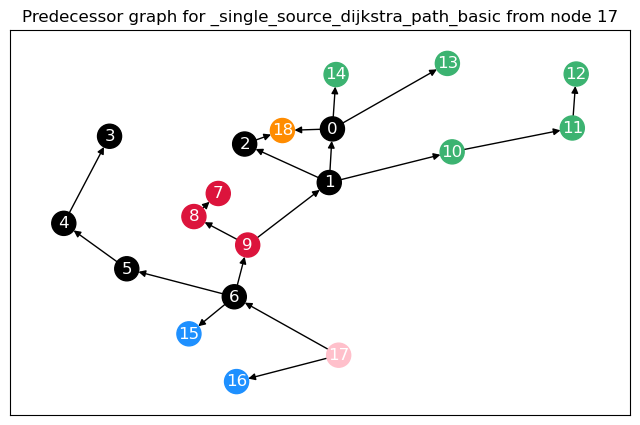

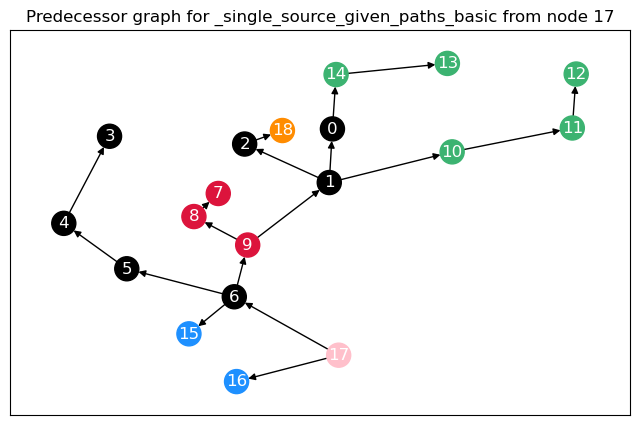

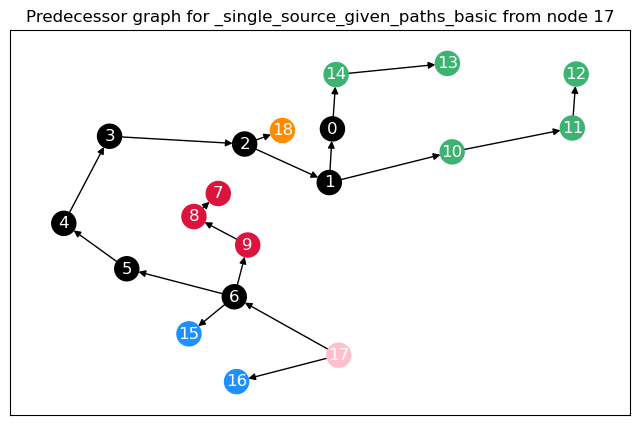

In [7]:
t = 17


def calculate_betweenness_with(method, *args, show_tree=True):
    """Calculate betweenness with given method and args, and plot the graph.
    Show tree graph of predecessors for node ``t``."""
    betweenness = dict.fromkeys(G, 0.0)
    betweenness_len = betweenness.copy()  # Length scaled betweenness
    betweenness_lin = betweenness.copy()  # Linear scaled betweenness
    betweenness_edge = betweenness.copy()
    betweenness_edge.update(dict.fromkeys(G.edges(), 0.0))
    betweenness_edge_len = betweenness_edge.copy()
    betweenness_edge_lin = betweenness_edge.copy()
    # b[v]=0 for v in G and b[e]=0 for e in G.edges
    # Loop over nodes to collect betweenness using pair-wise dependencies
    for s in G:
        S, P, sigma, D = method(G, s, *args)
        # betweenness, _ = _accumulate_basic(betweenness, S.copy(), P, sigma, s)
        # betweenness_edge = _accumulate_edges(betweenness_edge, S.copy(), P, sigma, s)
        delta = dict.fromkeys(S, 0)
        delta_len = delta.copy()
        while S:
            w = S.pop()
            coeff = (1 + delta[w]) / sigma[w]
            coeff_len = (1 / D[w] + delta[w]) / sigma[w] if D[w] != 0 else 0
            for v in P[w]:
                c = sigma[v] * coeff
                c_len = sigma[v] * coeff_len
                if (v, w) not in betweenness_edge:
                    betweenness_edge[(w, v)] += c
                    betweenness_edge_len[(w, v)] += c_len
                    betweenness_edge_lin[(w, v)] += D[w] * c_len
                else:
                    betweenness_edge[(v, w)] += c
                    betweenness_edge_len[(v, w)] += c_len
                    betweenness_edge_lin[(v, w)] += D[w] * c_len
                delta[v] += c
                delta_len[v] += sigma[v] * coeff_len
            if w != s:
                betweenness[w] += delta[w]
                betweenness_len[w] += delta_len[w]
                betweenness_lin[w] += D[w] * delta_len[w]
        if s == t and show_tree:
            plot_graph_from_predecessors(P, s, method.__name__)
    # Normalize betweenness values
    betweenness = _rescale(betweenness, len(G), normalized=True, directed=True)
    betweenness_len = _rescale(betweenness_len, len(G), normalized=True, directed=True)
    betweenness_lin = _rescale(betweenness_lin, len(G), normalized=True, directed=True)
    for n in G:  # Remove nodes
        del betweenness_edge[n]
        del betweenness_edge_len[n]
        del betweenness_edge_lin[n]
    betweenness_edge = _rescale_e(betweenness_edge, len(G), normalized=True,
                                  directed=True)
    betweenness_edge_len = _rescale_e(betweenness_edge_len, len(G), normalized=True,
                                      directed=True)
    betweenness_edge_lin = _rescale_e(betweenness_edge_lin, len(G), normalized=True,
                                      directed=True)
    return {
        "Node": betweenness,
        "Edge": betweenness_edge,
        "Node_len": betweenness_len,
        "Edge_len": betweenness_edge_len,
        "Node_lin": betweenness_lin,
        "Edge_lin": betweenness_edge_lin
    }


cb = calculate_betweenness_with(_single_source_dijkstra_path_basic, "weight")
cb_paths = calculate_betweenness_with(_single_source_given_paths_basic,
                                      node_order, pred, dist)
cb_restr = calculate_betweenness_with(_single_source_given_paths_basic,
                                      node_order, pred_restr, dist_restr)

Compare betweenness centrality values.

In [8]:
display(pd.DataFrame({
    ("", "C_B"): cb["Node"], ("", "C_B_paths"): cb_paths["Node"],
    ("", "C_B_restr"): cb_restr["Node"],
    ("Len scales", "C_B"): cb["Node_len"],
    ("Len scales", "C_B_paths"): cb_paths["Node_len"],
    ("Len scales", "C_B_restr"): cb_restr["Node_len"],
    ("Lin scales", "C_B"): cb["Node_lin"],
    ("Lin scales", "C_B_paths"): cb_paths["Node_lin"],
    ("Lin scales", "C_B_restr"): cb_restr["Node_lin"]
}
).sort_values(by=[("", "C_B")], ascending=False)
        .style.background_gradient(cmap="Blues", axis=None)
        .format(precision=3)
        .applymap_index(lambda x: f"color: {G.nodes[x]['partition']}" if x in G
                        .nodes else ""))

In [9]:
display(pd.DataFrame({
    ("", "C_B_e"): cb["Edge"], ("", "C_B_e_paths"): cb_paths["Edge"],
    ("", "C_B_e_restr"): cb_restr["Edge"],
    ("Len scales", "C_B_e"): cb["Edge_len"],
    ("Len scales", "C_B_e_paths"): cb_paths["Edge_len"],
    ("Len scales", "C_B_e_restr"): cb_restr["Edge_len"],
    ("Lin scales", "C_B_e"): cb["Edge_lin"],
    ("Lin scales", "C_B_e_paths"): cb_paths["Edge_lin"],
    ("Lin scales", "C_B_e_restr"): cb_restr["Edge_lin"]
}
).sort_values(by=[("Lin scales", "C_B_e_restr")], ascending=False)
        .style.background_gradient(cmap="Blues", axis=None)
        .format(precision=3)
        .applymap_index(lambda x: f"color: {G.nodes[x]['partition']}" if x in G
                        .nodes else ""))

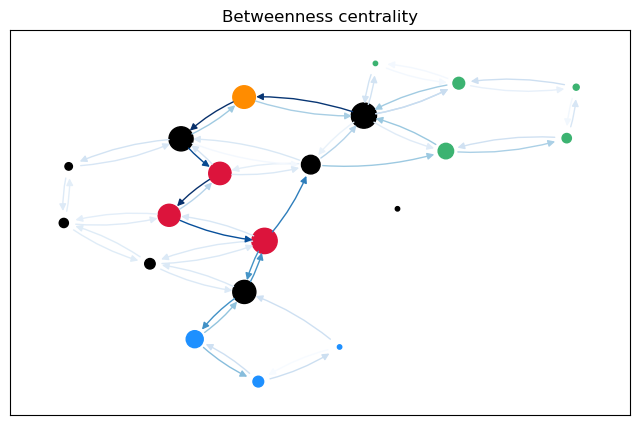

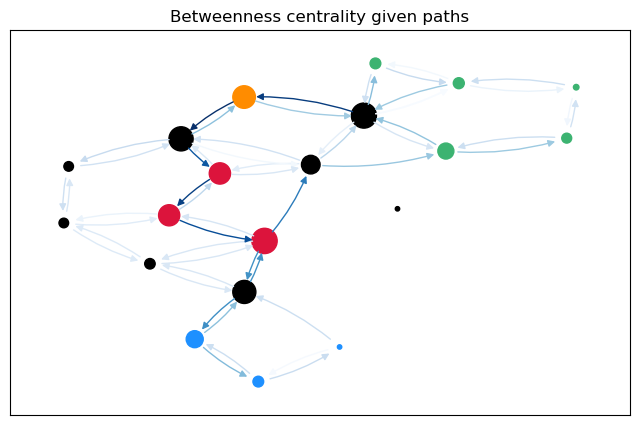

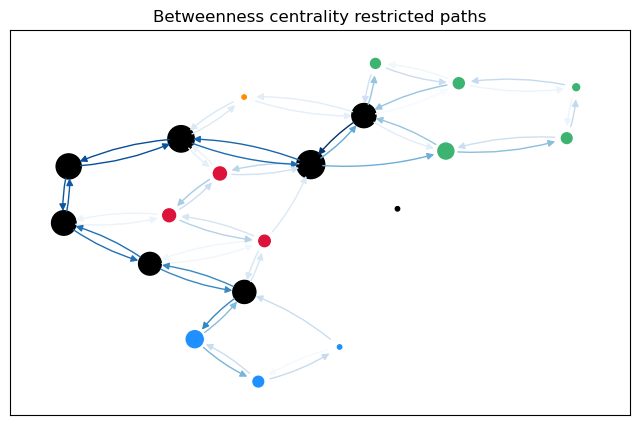

In [10]:
def betweenness_plot(G, cb, cb_e, title):
    """Plot graph with edge widths proportional to edge betweenness."""
    fig, ax = plt.subplots(figsize=(8, 5))
    pos = nx.kamada_kawai_layout(G, weight=None)
    nx.draw_networkx_nodes(
        G, pos=pos, ax=ax,
        node_color=[G.nodes[n]["partition"] for n in G.nodes],
        # linewidths=2,
        node_size=[v * 1000 + 10 for v in cb.values()],
    )
    e_col = nx.draw_networkx_edges(
        G, pos=pos, ax=ax,
        edge_color=[cb_e[(u, v)] for u, v in G.edges(keys=False)],
        edge_cmap=plt.cm.Blues,
        # alpha=0.8,
        # width=[v * 10 for v in cb_e.values()],
        connectionstyle="arc3,rad=0.1",
    )
    for col in e_col:
        col.set_zorder(2)
    # Add title
    ax.set_title(title)
    plt.show()


betweenness_plot(G, cb["Node"], cb["Edge"], "Betweenness centrality")
betweenness_plot(G, cb_paths["Node"], cb_paths["Edge"],
                 "Betweenness centrality given paths")
betweenness_plot(G, cb_restr["Node"], cb_restr["Edge"],
                 "Betweenness centrality restricted paths")

For our case of given graphs this can be simplified, as we always only have one path
between two nodes. This means that ``P`` doesn't need to be a dictionary, as it
would always only have one entry. All outputs can be lists. We do not need
``sigma`` as it would always be 2. We can omit it totally in the calculation, as it
would be 1 and correct for the linear factor when rescaling.

In [11]:
def _single_source_given_paths_simplified(dist_row):
    """Sort nodes, predecessors and distances by distance.

    Parameters
    ----------
    dist_row : np.array
        Distance row sorted non-decreasingly.

    Returns
    -------
    S : list
        List of node indices in order of distance.

    Notes
    -----
    Does not include endpoints.
    """
    dist_order = argsort(dist_row)
    try:
        # Remove unreachable indices (inf), check from back which is the first
        # reachable node
        while dist_row[dist_order[-1]] == np.inf:
            dist_order = dist_order[:-1]
        # Remove immediately reachable nodes with distance 0, including s itself
        while dist_row[dist_order[0]] == 0:
            dist_order = dist_order[1:]
    except IndexError:
        # If all nodes are unreachable, return empty list
        return []
    return list(dist_order)

In [12]:
def simplified_betweenness(node_order, edge_list, dist, pred):
    """Simplified betweenness centrality calculation."""
    node_indices = list(range(len(node_order)))
    betweenness = dict.fromkeys(node_indices, 0.0)
    betweenness_len = betweenness.copy()  # Length scaled betweenness
    betweenness_lin = betweenness.copy()  # Linear scaled betweenness
    betweenness_edge = betweenness.copy()
    betweenness_edge.update(dict.fromkeys(
        [(node_order.index(u), node_order.index(v)) for u, v in edge_list],
        0.0))
    betweenness_edge_len = betweenness_edge.copy()
    betweenness_edge_lin = betweenness_edge.copy()
    # b[v]=0 for v in G and b[e]=0 for e in G.edges
    # Loop over nodes to collect betweenness using pair-wise dependencies
    for s in node_indices:
        S = _single_source_given_paths_simplified(dist[s])
        # betweenness, _ = _accumulate_basic(betweenness, S.copy(), P, sigma, s)
        # betweenness_edge = _accumulate_edges(betweenness_edge, S.copy(), P, sigma, s)
        delta = dict.fromkeys(node_indices, 0)
        delta_len = delta.copy()
        # S is 1d-ndarray, while not empty
        while S:
            w = S.pop()
            # No while loop over multiple predecessors, only one path per node pair
            v = pred[s, w]  # P[w]
            d = dist[s, w]  # D[w]
            # Calculate dependency contribution
            coeff = 1 + delta[w]
            coeff_len = (1 / d + delta[w])
            # Add edge betweenness contribution
            if (v, w) not in betweenness_edge:
                betweenness_edge[(w, v)] += coeff
                betweenness_edge_len[(w, v)] += coeff_len
                betweenness_edge_lin[(w, v)] += d * coeff_len
            else:
                betweenness_edge[(v, w)] += coeff
                betweenness_edge_len[(v, w)] += coeff_len
                betweenness_edge_lin[(v, w)] += d * coeff_len
            # Add to dependency for further nodes/loops
            delta[v] += coeff
            delta_len[v] += coeff_len
            # Add node betweenness contribution
            if w != s:
                betweenness[w] += delta[w]
                betweenness_len[w] += delta_len[w]
                betweenness_lin[w] += d * delta_len[w]
    # Normalize betweenness values and rename node index keys to ids
    scale = 1 / ((len(node_order) - 1) * (len(node_order) - 2))
    for bc_dict in [betweenness, betweenness_len, betweenness_lin]:  # u_idx -> u_id
        for v in bc_dict.keys():
            bc_dict[v] *= scale
            v = node_order[v]
    for n in node_indices:  # Remove nodes
        del betweenness_edge[n]
        del betweenness_edge_len[n]
        del betweenness_edge_lin[n]
    scale = 1 / (len(node_order) * (len(node_order) - 1))
    for bc_e_dict in [betweenness_edge, betweenness_edge_len,
                      betweenness_edge_lin]:  # (u_idx, v_idx) -> (u_id, v_id)
        for e in bc_e_dict.keys():
            bc_e_dict[e] *= scale
            e = (node_order[e[0]], node_order[e[1]])

    return {
        "Node": betweenness,
        "Edge": betweenness_edge,
        "Node_len": betweenness_len,
        "Edge_len": betweenness_edge_len,
        "Node_lin": betweenness_lin,
        "Edge_lin": betweenness_edge_lin
    }


cb_paths_2 = simplified_betweenness(node_order, G.edges(keys=False), dist, pred)
cb_restr_2 = simplified_betweenness(node_order, G.edges(keys=False), dist_restr,
                                    pred_restr)

In [13]:
# Check if results are the same when unsimplified
cb_paths["Edge"] == cb_paths_2["Edge"]
for k, v in cb_paths.items():
    print(
        f"{k}: {all([np.isclose(cb_paths[k][k1], cb_paths_2[k][k1]) for k1 in cb_paths[k].keys()])}")
    print(f"keys: {v.keys() == cb_paths_2[k].keys()}")
    for k1, val1 in v.items():
        val2 = cb_paths_2[k][k1]
        if not np.isclose(val1, val2):
            print(val1, val2)

Node: True
keys: True
Edge: True
keys: True
Node_len: True
keys: True
Edge_len: True
keys: True
Node_lin: True
keys: True
Edge_lin: True
keys: True


Compare performance

In [14]:
%timeit calculate_betweenness_with(_single_source_dijkstra_path_basic, "weight", show_tree=False)
%timeit calculate_betweenness_with(_single_source_given_paths_basic, node_order, pred, dist, show_tree=False)
%timeit simplified_betweenness(node_order, G.edges(keys=False), dist, pred)

4.81 ms ± 344 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
11.3 ms ± 423 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
9.03 ms ± 120 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
